In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
olivetti = fetch_olivetti_faces()
olivetti.data

array([[0.30991736, 0.3677686 , 0.41735536, ..., 0.15289256, 0.16115703,
        0.1570248 ],
       [0.45454547, 0.47107437, 0.5123967 , ..., 0.15289256, 0.15289256,
        0.15289256],
       [0.3181818 , 0.40082645, 0.49173555, ..., 0.14049587, 0.14876033,
        0.15289256],
       ...,
       [0.5       , 0.53305787, 0.607438  , ..., 0.17768595, 0.14876033,
        0.19008264],
       [0.21487603, 0.21900827, 0.21900827, ..., 0.57438016, 0.59090906,
        0.60330576],
       [0.5165289 , 0.46280992, 0.28099173, ..., 0.35950413, 0.3553719 ,
        0.38429752]], dtype=float32)

In [4]:
strat = StratifiedShuffleSplit(n_splits=1,test_size=40, random_state=42)
train_indx, test_indx = next(strat.split(olivetti.data, olivetti.target))

X_train, y_train = olivetti.data[train_indx], olivetti.target[train_indx]
X_test, y_test = olivetti.data[test_indx], olivetti.target[test_indx]

strat = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_indx, val_indx = next(strat.split(X_train, y_train))
X_train, y_train = olivetti.data[train_indx], olivetti.target[train_indx]
X_val, y_val = olivetti.data[val_indx], olivetti.target[val_indx]

In [5]:
from sklearn.decomposition import PCA

In [6]:
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)


pca.n_components_

200

In [7]:
from sklearn.cluster import KMeans

In [8]:
n_k = range(5, 150, 5)
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_train_pca) for k in n_k]
kmeans_per_k

[KMeans(n_clusters=5, random_state=42),
 KMeans(n_clusters=10, random_state=42),
 KMeans(n_clusters=15, random_state=42),
 KMeans(n_clusters=20, random_state=42),
 KMeans(n_clusters=25, random_state=42),
 KMeans(n_clusters=30, random_state=42),
 KMeans(n_clusters=35, random_state=42),
 KMeans(n_clusters=40, random_state=42),
 KMeans(n_clusters=45, random_state=42),
 KMeans(n_clusters=50, random_state=42),
 KMeans(n_clusters=55, random_state=42),
 KMeans(n_clusters=60, random_state=42),
 KMeans(n_clusters=65, random_state=42),
 KMeans(n_clusters=70, random_state=42),
 KMeans(n_clusters=75, random_state=42),
 KMeans(n_clusters=80, random_state=42),
 KMeans(n_clusters=85, random_state=42),
 KMeans(n_clusters=90, random_state=42),
 KMeans(n_clusters=95, random_state=42),
 KMeans(n_clusters=100, random_state=42),
 KMeans(n_clusters=105, random_state=42),
 KMeans(n_clusters=110, random_state=42),
 KMeans(n_clusters=115, random_state=42),
 KMeans(n_clusters=120, random_state=42),
 KMeans(n_cl

In [9]:
from sklearn.metrics import silhouette_score

In [10]:
silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = n_k[best_index]
best_score = silhouette_scores[best_index]
best_score
best_k

110

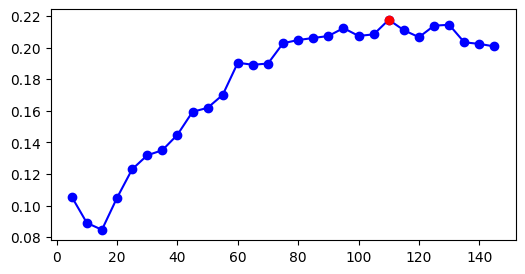

In [11]:
plt.figure(figsize=(6,3))
plt.plot(n_k, silhouette_scores, "bo-")
plt.plot(best_k, best_score, "ro")

In [12]:
best_model = kmeans_per_k[best_index]

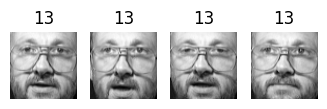

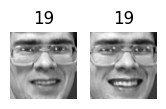

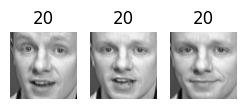

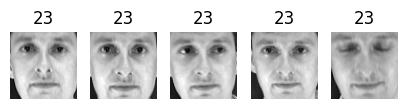

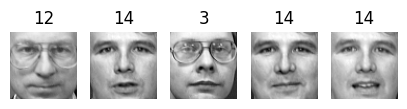

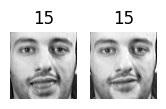

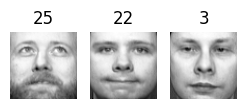

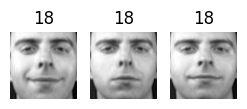

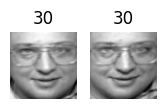

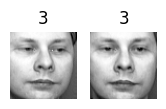

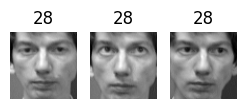

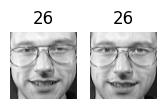

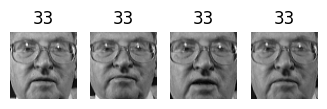

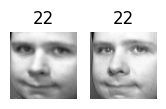

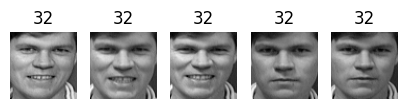

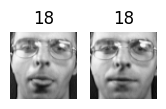

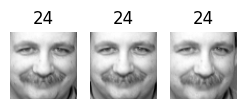

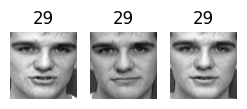

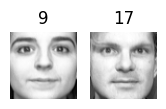

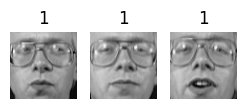

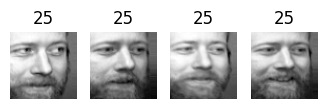

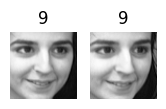

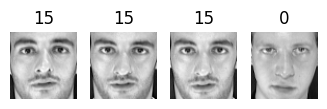

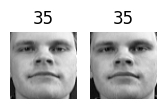

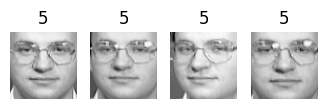

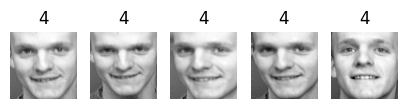

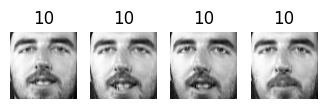

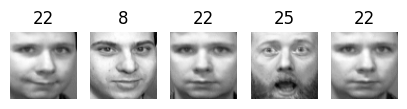

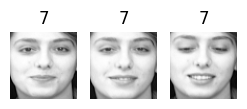

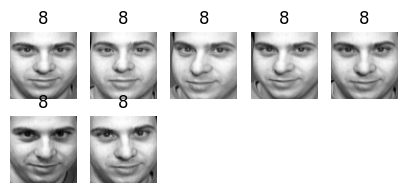

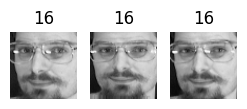

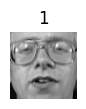

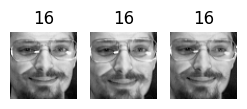

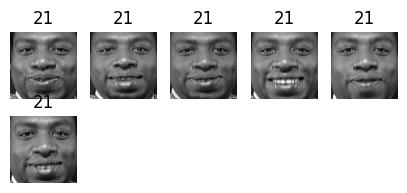

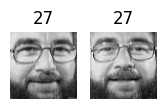

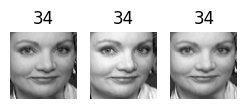

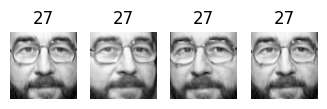

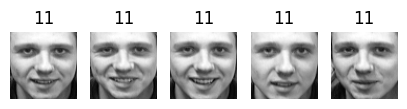

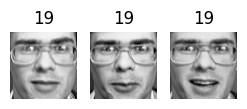

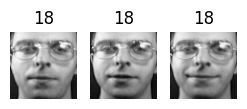

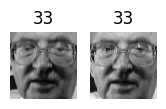

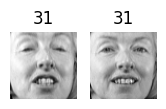

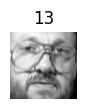

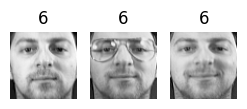

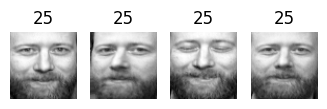

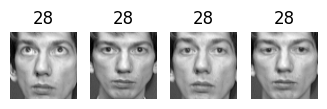

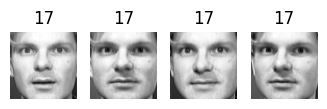

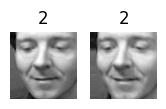

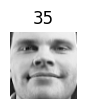

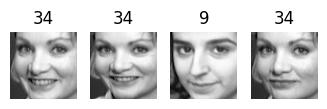

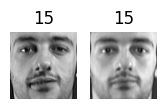

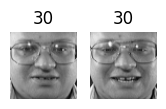

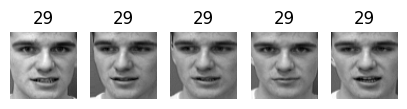

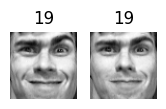

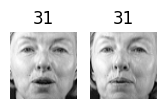

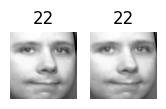

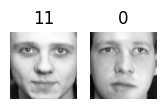

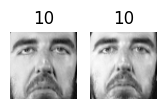

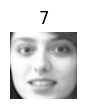

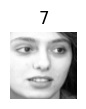

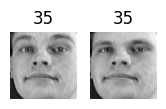

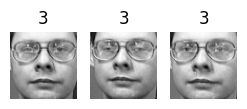

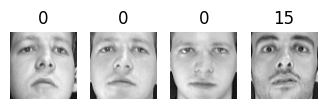

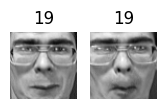

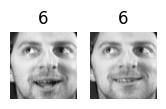

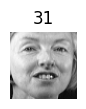

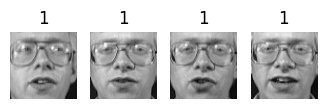

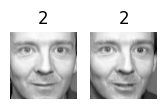

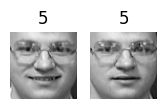

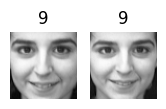

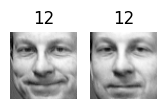

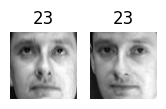

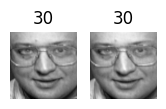

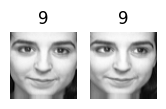

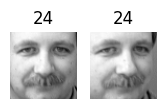

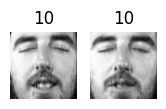

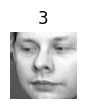

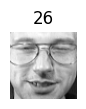

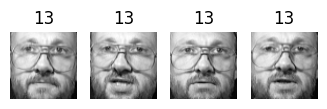

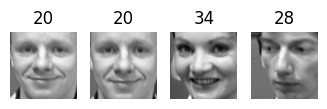

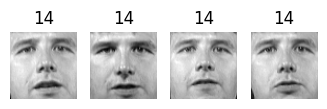

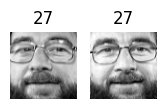

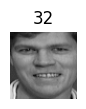

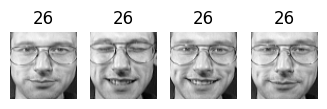

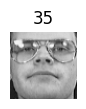

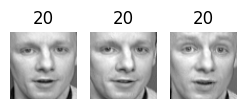

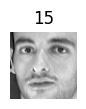

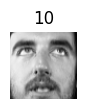

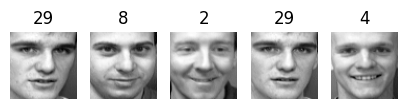

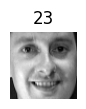

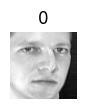

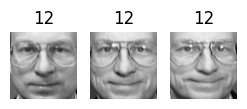

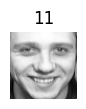

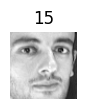

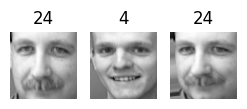

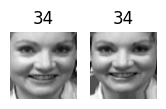

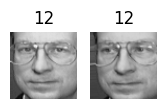

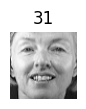

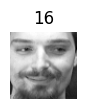

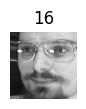

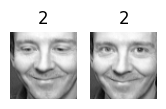

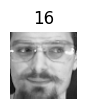

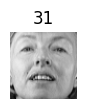

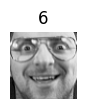

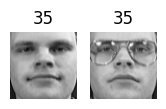

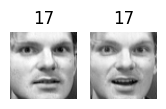

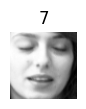

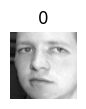

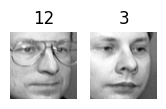

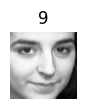

In [13]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in np.unique(best_model.labels_):
    in_cluster = best_model.labels_ == cluster_id
    faces = X_train[in_cluster]
    labels = y_train[in_cluster]
    plot_faces(faces, labels)

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
rnd_clf = RandomForestClassifier(n_estimators=150, random_state=42)
rnd_clf.fit(X_train_pca, y_train)
rnd_clf.score(X_val_pca, y_val)

0.9375

In [16]:
X_train_reduced = best_model.transform(X_train_pca)
X_test_reduced = best_model.transform(X_test_pca)
X_val_reduced = best_model.transform(X_val_pca)

rnd_clf = RandomForestClassifier(n_estimators=150, random_state=42)
rnd_clf.fit(X_train_reduced, y_train)
rnd_clf.score(X_val_reduced, y_val)

0.7

In [17]:
from sklearn.pipeline import Pipeline

In [18]:
for k in n_k:
    pipeline = Pipeline([("kmeans",KMeans(n_clusters=k, random_state=42)),
             ("rnd_clf", RandomForestClassifier(n_estimators=150, random_state=42))])
    
    pipeline.fit(X_train_pca, y_train)
    print(k, pipeline.score(X_val_pca, y_val))

5 0.5
10 0.5375
15 0.6125
20 0.575
25 0.65
30 0.65
35 0.65
40 0.7375
45 0.6875
50 0.75
55 0.7125
60 0.7375
65 0.725
70 0.725
75 0.7125
80 0.7375
85 0.75
90 0.75
95 0.725
100 0.7375
105 0.7375
110 0.7
115 0.75
120 0.775
125 0.7125
130 0.75
135 0.725
140 0.7375
145 0.725


In [19]:
X_train_extended = np.c_[X_train_pca, X_train_reduced]
X_test_extended = np.c_[X_test_pca, X_test_reduced]
X_val_extended = np.c_[X_val_pca, X_val_reduced]

In [20]:
rnd_clf = RandomForestClassifier(n_estimators=150, random_state=42)
rnd_clf.fit(X_train_extended, y_train)
rnd_clf.score(X_val_extended, y_val)

0.75

In [21]:
from sklearn.mixture import GaussianMixture

In [22]:
gm = GaussianMixture(n_components=40, random_state=42)
y_pred = gm.fit_predict(X_train_pca)

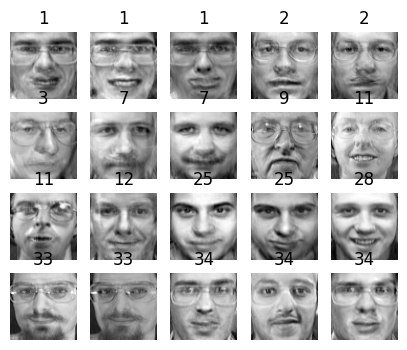

In [23]:
X_new_samples, y_new_samples = gm.sample(n_samples=20)
new_faces = pca.inverse_transform(X_new_samples)
plot_faces(new_faces, y_new_samples)